<a href="https://colab.research.google.com/github/Alenushka2013/Coursera/blob/master/214747_5_1_Simple_Machine_Learning_%7C_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Мы будем использовать модель MANUela ML в качестве примера блокнота для изучения различных компонентов, необходимых для машинного обучения. Данные, используемые для обучения модели, находятся в файле raw-data.csv .

Блокнот следует рабочему процессу, показанному ниже на рисунке., где приведено объяснение шагов.

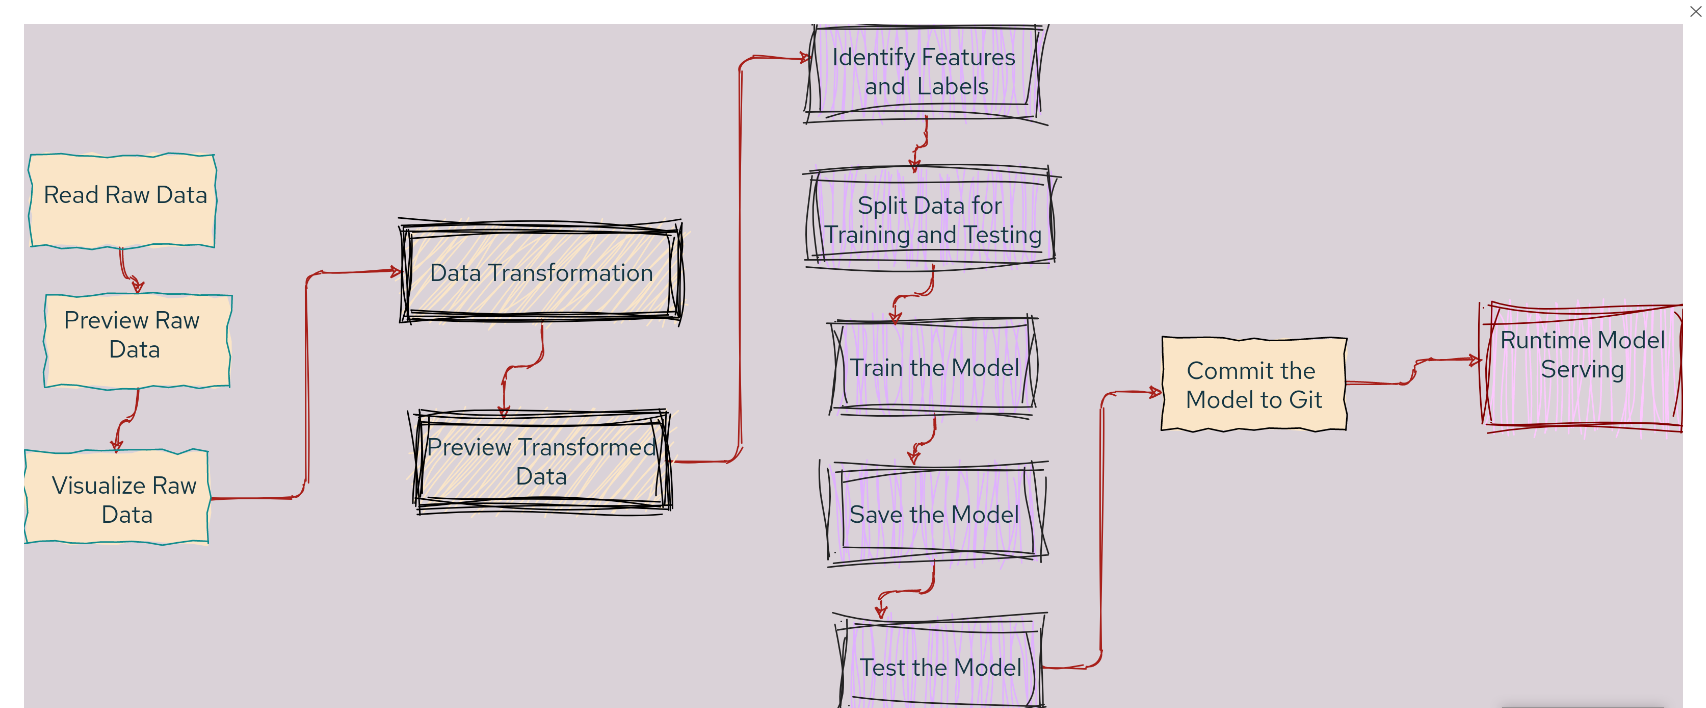

# Шаг 1: Изучите необработанные данные

Используйте ячейку кода для импорта требуемых библиотек Python. Затем преобразуйте файл необработанных данных ( raw-data.csv) в файл DataFrameс временным рядом, идентификатором насоса, значением вибрации и меткой, указывающей на аномалию.

In [3]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/raw-data.csv')

In [5]:
df.head()

,ts,id,value,label
0,1587640434617,pump-1,18.340181,0
1,1587640437999,pump-2,12.703972,0
2,1587640439618,pump-1,17.647661,0
3,1587640442999,pump-2,13.805114,0
4,1587640444617,pump-1,16.874933,0


In [6]:
df['time'] = pd.to_datetime(df['ts'], unit = 'ms')
df.set_index('time', inplace = True)
df.drop(columns = ['ts'], inplace = True)

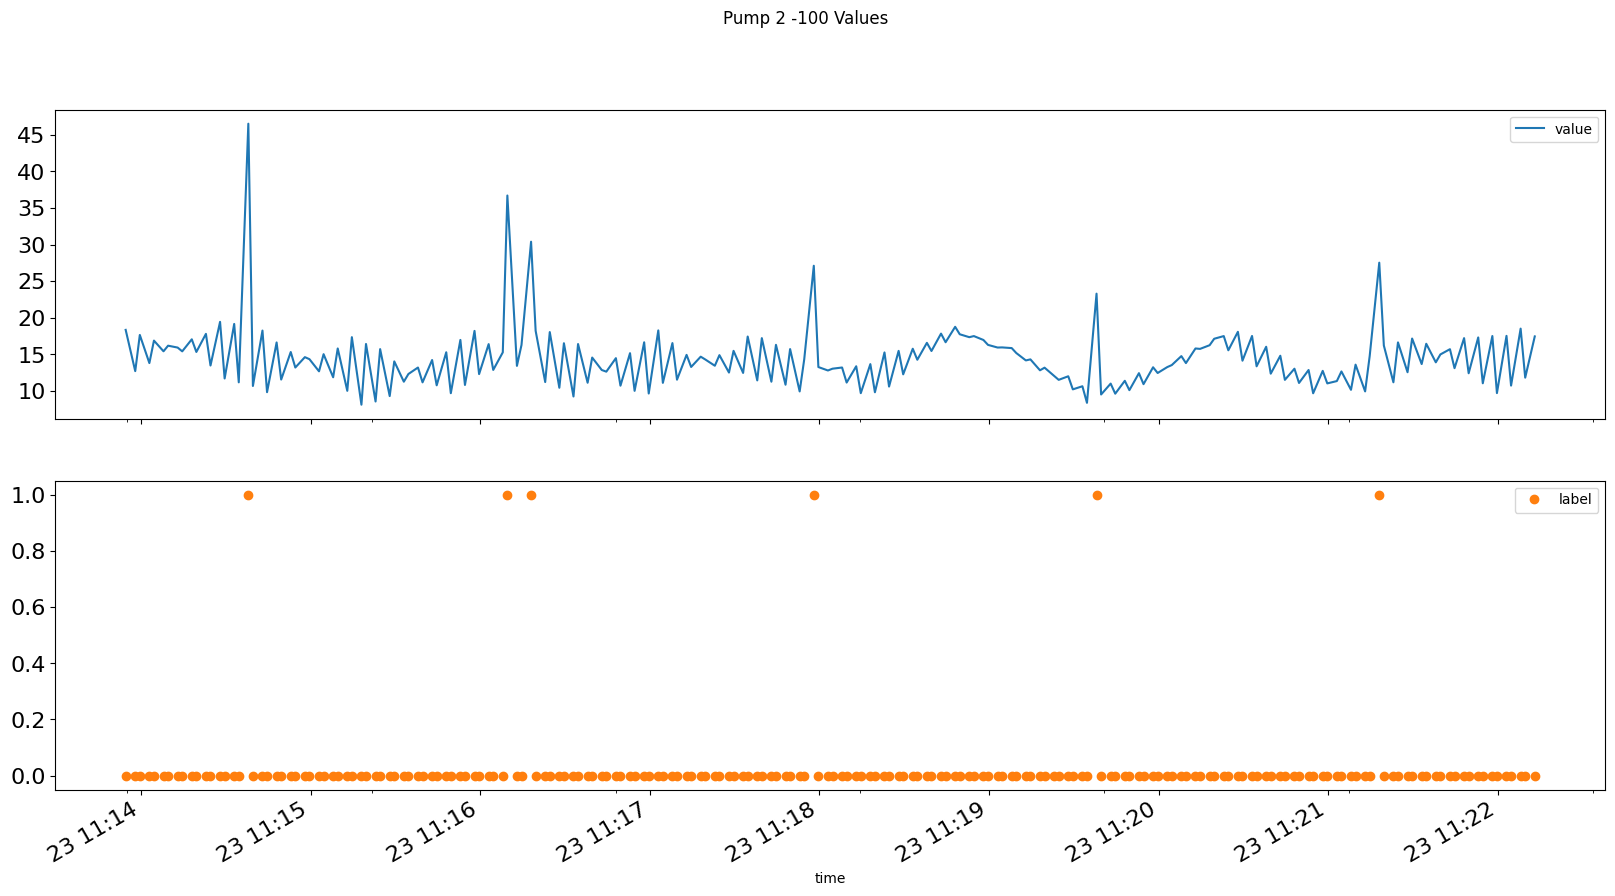

In [7]:
df21 = df.head(200)
df21.plot(figsize = (20, 10), fontsize = 16, subplots = True, style = ["-", "o"], title = "Pump 2 -100 Values")
plt.show()

# Преобразование, очистка и структурирование необработанных данных

Прежде чем их можно будет проанализировать, необработанные данные необходимо преобразовать, очистить и структурировать в другие форматы, более подходящие для анализа. Этот процесс называется обработкой данных.

Мы будем преобразовывать необработанные данные временных рядов в небольшие эпизоды, которые можно использовать для контролируемого обучения.

In [8]:
# Few helper functions

# Get list with column names: F1, F2, Fn, L
def get_columns(n):
    return [f"F{x}" for x in range(1, n + 1)] + ["L"]

# Create empty data frame
def create_empty_df(n):
    return pd.DataFrame(columns=get_columns(n))

 # Create data frame with one row
def create_df(vals: list, label: int = 0):
    if not isinstance(vals, list):
        raise TypeError
    return pd.DataFrame([vals + [label]], columns=get_columns(len(vals)))

Давайте теперь преобразуем наши данные временного ряда в эпизоды

In [9]:
length = 5 # Episode length

df_epis = create_empty_df(length)
all_rows = [] # Список для хранения DataFrame отдельных строк

for id in df.id.unique():
    print("Convert data for: ", id)
    df2 = df.loc[df['id'] == id]
    epi = []

    for index, row in df2.iterrows():
        epi.append(row['value'])
        if len(epi) == length:
            df_row = create_df(epi, row['label'])
            # Добавляем DataFrame строки в список
            all_rows.append(df_row)
            del epi[0]

# Объединяем все DataFrame строк в один df_epis
df_epis = pd.concat(all_rows, ignore_index=True)

Convert data for:  pump-1
Convert data for:  pump-2


# Шаг 2: Функциональные и целевые столбцы

Как и многие библиотеки машинного обучения, Sklern требует отдельных столбцов признаков (X) и целей (Y).

In [10]:
# Extract feature columns
feature_cols = list(df_epis.columns[:-1])

# Extract target column 'label'
target_col = df_epis.columns[-1]

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X and y)
X = df_epis[feature_cols]
y = df_epis[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X.head())

Feature columns:
['F1', 'F2', 'F3', 'F4', 'F5']

Target column: L

Feature values:
          F1         F2         F3         F4         F5
0  18.340181  17.647661  16.874933  16.180807  15.407113
1  17.647661  16.874933  16.180807  15.407113  15.324012
2  16.874933  16.180807  15.407113  15.324012  13.470387
3  16.180807  15.407113  15.324012  13.470387  11.702384
4  15.407113  15.324012  13.470387  11.702384  11.176102


# Шаг 3: Обучение и тестирование наборов данных

Хорошей практикой является разделение набора данных на два подмножества: одно для обучения модели и другое для тестирования обученной модели.

Наша цель — создать модель, которая хорошо обобщается на новые данные. Наш тестовый набор будет служить прокси для новых данных. Мы разделим набор данных на 67% для обучающих наборов и 33% для тестового набора

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Show the results of the split
print('Training set has {} samples.'.format(X_train.shape[0]))
print('Testing set has {} samples.'.format(X_test.shape[0]))

print('Anomaly rate of the training set: {:.2f}%'.format(100 * (y_train == 1).mean()))
print('Anomaly rate of the tseting set: {:.2f}%'.format(100 * (y_test == 1).mean()))

Training set has 2019 samples.
Testing set has 995 samples.
Anomaly rate of the training set: 2.72%
Anomaly rate of the tseting set: 2.91%


# Шаг 4: Обучение модели

Мы выполним обучение модели с помощью DecisionTreeClassifier. Деревья решений — это контролируемый метод обучения, используемый для классификации и регрессии. Цель состоит в том, чтобы создать модель, которая предсказывает значение целевой переменной, обучаясь простым правилам принятия решений, выведенным из особенностей данных.

DecisionTreeClassifier— это класс, который выполняет многоклассовую классификацию набора данных, хотя в этом примере мы будем использовать его для классификации в один класс. DecisionTreeClassifierпринимает в качестве входных данных два массива: массив X в качестве признаков и массив Y в качестве меток. После подгонки модель может использоваться для прогнозирования меток для тестового набора данных.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

my_random_seed = 42

# Initialize the DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = my_random_seed)

# train the classifier
model.fit(X_train, y_train)

# Predict with the test data
y_predict = model.predict(X_test)

# Determine the accuracy score
accuracy_score = accuracy_score(y_test, y_predict)

print("Accuracy score for the trained model: {:.4f}.".format(accuracy_score))

Accuracy score for the trained model: 1.0000.


# Шаг 5: Сохраните модель

Сохраните модель и загрузите ее снова, чтобы проверить ее работоспособность

In [14]:
from joblib import dump, load

filename = 'model.joblib'
dump(model, open(filename, 'wb'))
# Validate that the model can be loaded

# load the model from disk
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print('Score:', result)


Score: 1.0


# Шаг 6: Вывод с помощью модели

Теперь, когда мы создали модель машинного обучения, мы можем использовать ее для вывода данных в реальном времени.

В этом примере мы будем использовать Seldon для обслуживания модели. Чтобы наша модель работала под Seldon, нам нужно создать класс, который имеет метод predict. Метод predict может получать массив NumPy X и возвращать результат прогноза как:

    Массив NumPy
    Список ценностей
    Строка байтов


In [19]:
import os, sys

class AnomalDetection(object):
  def __init__(self):
    print("Initializing...")
    self.model_file = os.environ.get("MODEL_FILE", "model.joblib")

    print("Load modelfile: %s" % (self.model_file))
    self.clf = load(open(self.model_file, 'rb'))

  def predict(self, X, feature_names):
    print("Predicted features: ", X)

    prediction = self.clf.predict(X)
    print("Prediction: ", prediction)

    return prediction

**Проверка модели**

Наконец, давайте проверим, может ли модель предсказывать аномалии для списка значений

In [20]:
import numpy as np
p = AnomalDetection()

X = np.asarray([[16.1, 15.40, 15.32, 13.47, 17.7]], dtype = np.float32)
print("Features types: ", type(X), type(X[0][0]))
print("Predict features: ", X)

prediction = p.clf.predict(X)
print("Prediction: ", prediction)

Initializing...
Load modelfile: model.joblib
Features types:  <class 'numpy.ndarray'> <class 'numpy.float32'>
Predict features:  [[16.1  15.4  15.32 13.47 17.7 ]]
Prediction:  [0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
